### This notebook is designed to make a Dataframe with rear events and trajectories surroundin it 
Make one large data frame with all rears. 
Then it shoud calculate the dxiaplcement between X and y and potl it againt Z

# TODO: 

make an average displacement plot 

Add if rear is in invisble condition or visible 

REFACTOR...


In [2]:
import math
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from numpy import median
from scipy.stats import ranksums
import numpy as np
import scipy.stats
import os
import fnmatch
import rear_analysis
from datetime import datetime
import csv
import h5py

#### imports for a sample session

In [3]:
root = '//10.153.170.3/storage2/fabian/data/project/CALIBRATION/'
root3 = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS03/'
root4 = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS04/'
figures = 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/Figures/'
animal = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS03/'
processed= 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/processed/'

#need to correct this and uncomment all esle

# laptop_root = 'C:/Users/Fabian/Desktop/Rearing_analysis/Data/FS10/BPositions_FS10_20211006-154014/'
# FS03_position=pd.read_csv(laptop_root+'position_20211006-154014.txt',sep=" ", header=None)
# FS03_beacon=pd.read_csv(laptop_root+'beacons_20211006-154014.txt',sep=" ", header=None)
# FS03_metadata= pd.read_csv(laptop_root+'metadata_20211006-154014.txt',sep=" : ", header=None, index_col=0).T

    

FS03_position= pd.read_csv(root3+'position_20210312-172823.txt',sep=" ", header=None)
FS04_position = pd.read_csv(root4+'position_20210322-202458.txt',sep=" ", header=None)

FS03_beacon = pd.read_csv(root3+'beacons_20210312-172823.txt',sep=" ", header=None)
FS04_beacon = pd.read_csv(root4+'beacons_20210322-202458.txt',sep=" ", header=None)

FS03_metadata = pd.read_csv(root3+'metadata_20210312-172823.txt',sep=" : ", header=None, index_col=0).T

pd.options.display.float_format = '{:.3f}'.format
FS03_metadata
invisible_time = eval(FS03_metadata['invisible_time'].item())
invisible_time

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


60

In [4]:
FS03_position.head()

,0,1,2,3,4,5,6,7,8,9
0,1615566503.650,0.068,0.473,0.311,-8.803,-173.105,-16.893,1810,13075943.081,0.208
1,1615566503.660,0.067,0.478,0.318,-6.802,-172.775,-14.545,1812,13075943.097,0.225
2,1615566503.680,0.066,0.485,0.327,-5.331,-173.292,-10.482,1814,13075943.114,0.242
3,1615566503.690,0.064,0.494,0.336,-3.791,-173.008,-6.319,1816,13075943.131,0.258
4,1615566503.710,0.065,0.502,0.345,-4.207,-172.265,-4.026,1818,13075943.147,0.275


### Rotation format - dont care about rotation if the cut off on the walls are set correctly. 

In [5]:
##(xcosθ−ysinθ ,xsinθ+ycosθ).
def rotation_correction_points(position_data,alpha=1.7):
    alpha = (alpha) * np.pi / 180
    rot_position_data = position_data
    rot_position_data[1] = position_data[1] * np.cos(alpha) - position_data[3] * np.sin(alpha)
    rot_position_data[3] = position_data[1] * np.sin(alpha) + position_data[3] * np.cos(alpha)
    return rot_position_data
def rotation_correction_beacons(position_data,alpha=-5):
    alpha = (alpha) * np.pi / 180
    rot_position_data = position_data
    rot_position_data["BeaconX"] = position_data["BeaconX"] * np.cos(alpha) - position_data["BeaconY"] * np.sin(alpha)
    rot_position_data["BeaconY"] = position_data["BeaconX"] * np.sin(alpha) + position_data["BeaconY"] * np.cos(alpha)
    return rot_position_data


### Steps to do to the data: 
    
    0th - get proper vut offs for borderless arena 
    A.Make rearign file >.62 where time XYZ of detected rear 
    B. Use those indexes from rearign file to index into the rearign and generate rearign trajectories before and after. 
    C. Plot trajectories.
    D. Generate histogram of how long a rear would last. - Just find index of last and first and get the difference between the times 
    C. Index into rearign which are only within the arena 
    D. Index into only those that have an invisible condition 
    E. Calculate how far from beacon that rear is - plot rears only within 0-30 cm away from beacon 
    D. Calculate the X and Y displacement. 
    
 

### Borders of arena - hardcoded from calibration file 

In [6]:
cut = 0 # keeping the cut where rectangle of arena ends
X_cut_min = -.59
Y_cut_max = 1.61
X_cut_max = .12
Y_cut_min = .00
print("area %s M*2" %((X_cut_max-X_cut_min)*(Y_cut_max-Y_cut_min))) 
#Translations
x_max, x_min = 0.12, -0.59
x_offset = x_max - (x_max - x_min)/2
y_max, y_min = 1.61,  0
y_offset = y_max - (y_max - y_min)/2
print(x_offset,y_offset)
xcut_offset=-.24
ycut_offset=-.8
#alpha
rotation= 1.7

area 1.1431 M*2
-0.235 0.805


### Show Output from Arena with added beacons - They were a bit off to begin with and shoudl be so for calculations

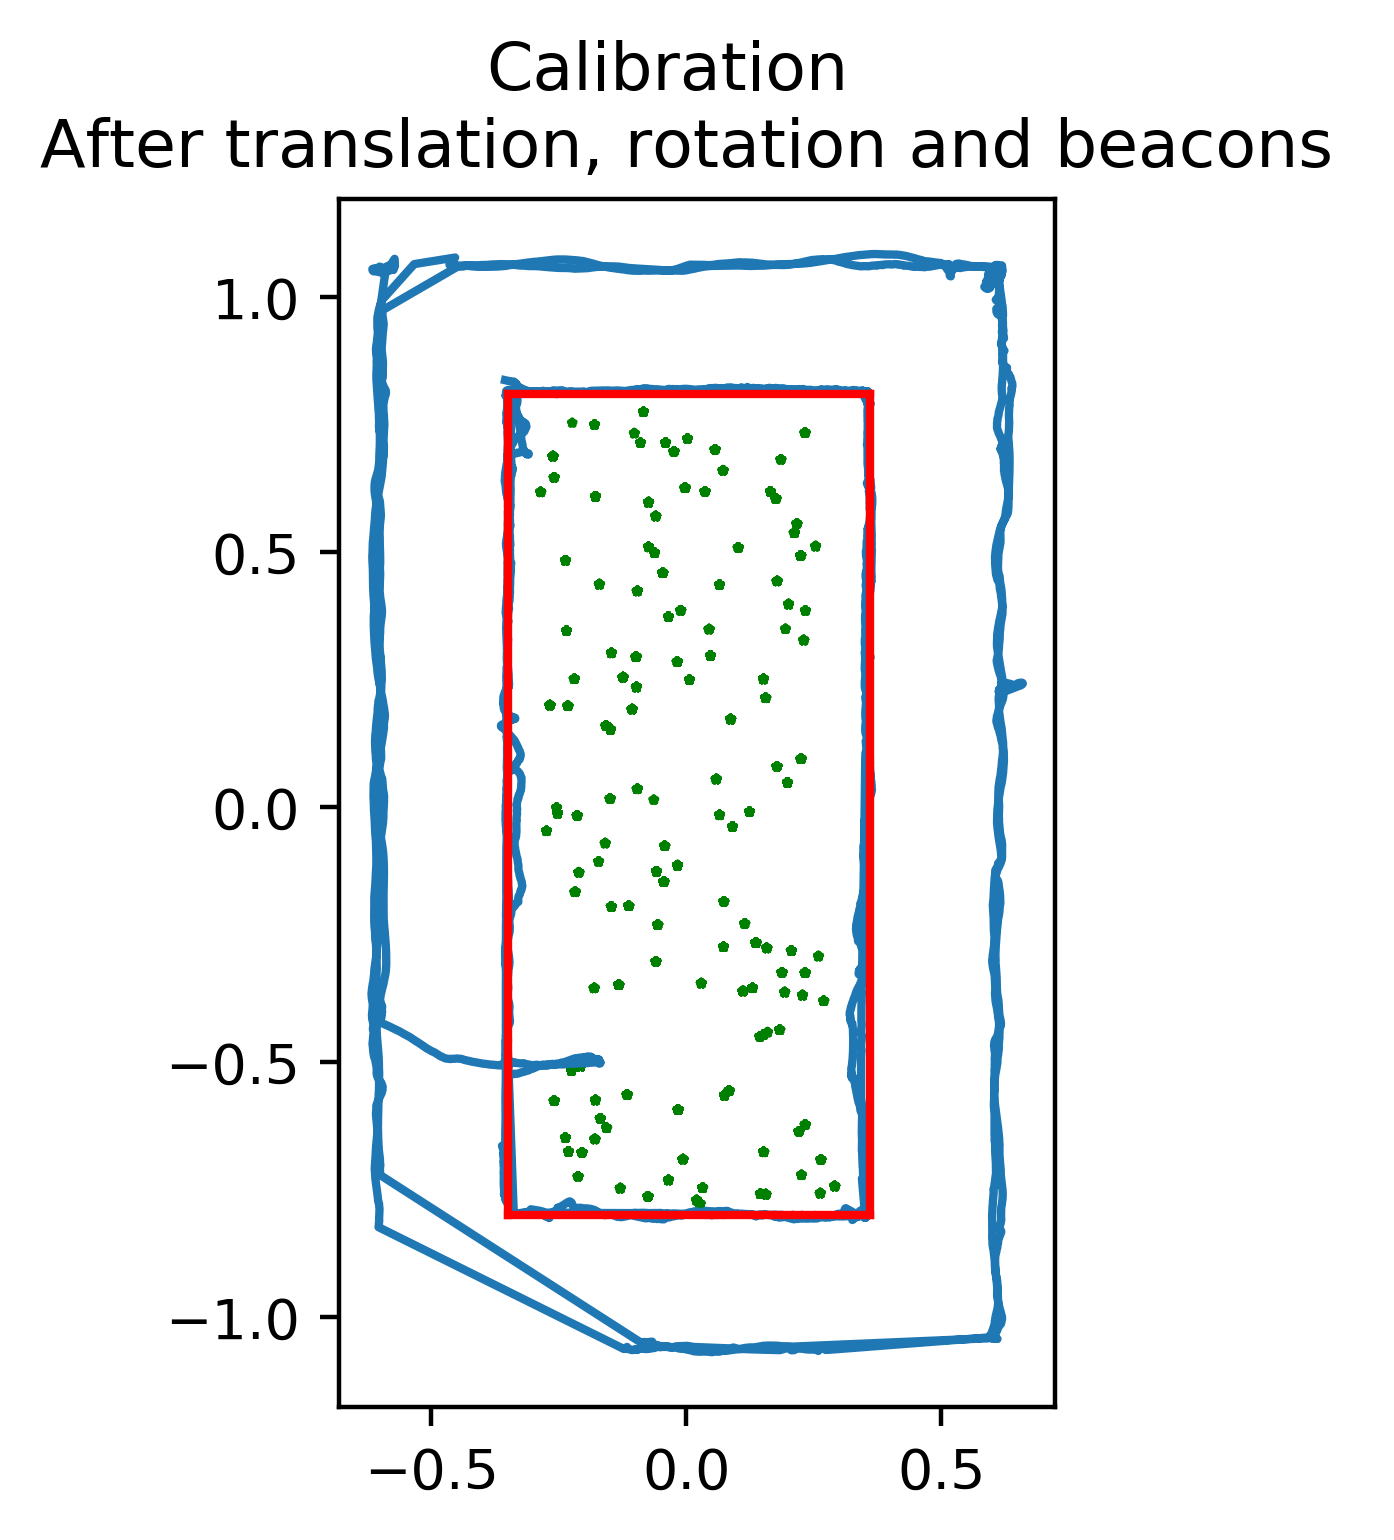

In [7]:
CALIB1 = pd.read_csv(root+'BPositions_CALIBRATION_20210610-111132/position_20210610-111132.txt',sep=" ", header=None)    
CALIB1[1]= CALIB1[1]-xcut_offset
CALIB1[3]= CALIB1[3]+ycut_offset
rot_position_data=  rotation_correction_points(CALIB1,alpha=1.7)
fig, ax1 = plt.subplots(1, 1, sharex=True,dpi=400, sharey=True)
fig.suptitle("Calibration")
ax1.set_title('After translation, rotation and beacons ')
rearing3 = pd.read_excel(processed +'FS11_rears_new.xlsx')
rearing3 = rotation_correction_beacons(rearing3,alpha=-5)
ax1.plot(rot_position_data[1],rot_position_data[3])
ax1.plot([(X_cut_min+cut)-xcut_offset,(X_cut_max-cut)-xcut_offset],[(Y_cut_max-cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
ax1.plot([(X_cut_min+cut)-xcut_offset,(X_cut_min+cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
ax1.plot([(X_cut_max-cut)-xcut_offset,(X_cut_max-cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
ax1.plot([(X_cut_max-cut)-xcut_offset,(X_cut_min+cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_min+cut)+ycut_offset] ,'r-')
ax1.scatter(rearing3["BeaconX"],rearing3["BeaconY"],s=1,marker='*', facecolors='none', edgecolors='green')
plt.gca().set_aspect('equal')

### A. get secific point per rear event in center of arena

In [7]:
def Z_period_dynamics(positions,In_arena = True):
    """get every rear event in center of arena
    
    If animal gets above .62 detect it as one until below again
    
    PARAMS
    ------------
    positions : DataFrame 
    
    Returns
    ------------
    Data Frame with all rears position (begining of rear) and time. 

    """
    high =0 
    low = 0
    switch = 0 
    last = .60
    high_points=[]
    z= positions[2]
    count = 0 
    for height in z: 
        if height >.62 and last<.62:
            high +=1  
            if In_arena:
                if (X_cut_min + cut) < positions[1][count] < (X_cut_max - cut) and (Y_cut_min + cut) < positions[3][
                    count] < (Y_cut_max - cut):
                    high_points.append((positions[0][count], positions[1][count], positions[3][count], positions[2][count]))
            else:
                high_points.append((positions[0][count], positions[1][count], positions[3][count], positions[2][count]))
        last = height
        count +=1
    return pd.DataFrame(high_points)
Z_points_in= Z_period_dynamics(FS03_position,In_arena = True)
Z_points_out= Z_period_dynamics(FS03_position,In_arena = False)
Z_points_in.equals(Z_points_out)
Z_points=Z_period_dynamics(FS03_position,In_arena = True)
print(Z_points_in.shape)
Z_points_out.shape


(142, 4)


(271, 4)

In [8]:
window_beg=20
window_end=120

def make_rear_dyn(position_data, rear_time ,metadata, window_beg=window_beg,window_end=window_end,in_arena=True):
    """
    
    Create cut of trajectories from around a detected rear. 
    
    PARAMS
    ------------
    positions : DataFrame 
    rear_time :data frame of timing of rears
    metadata : data frame of metadat to be used for invisible rears and attempts. 
    
    Returns
    ------------
    trial_list: list of numpy arrays position data [time, x, y, z] with windows defined in samples. 
    rear_time: list of rears detected
    trial_visible: list of booleans referring visibility of trial (True - visible, False- invisible
    before_beacon: list of positions before the first beacon appears
    """

    trial_list = []
    #print(beacon_data.iloc[:, -2:])
    trial_beacon = rear_time.iloc[:, -2:]
    sampling_rate = position_data.iloc[1, 0] - position_data.iloc[0, 0]
    rear_time_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time.iloc[:, 0]
    ]

    trial_list.append(position_data[:rear_time_idx[0]])
    for i in range(len(rear_time_idx)):
        if i != len(rear_time_idx) - 1:
            trial = position_data[
                rear_time_idx[i]-window_beg:rear_time_idx[i]+window_end]
        else:
            trial = position_data[rear_time_idx[i]:]
        trial_list.append(trial)
    before_beacon = position_data[:rear_time_idx[0]]
    visible = []
    trial_visible = [True] * len(trial_list)
    invisible_time = eval(metadata['invisible_time'].item())
    invisible_index = eval(metadata['invisible_list'].item())

    for n, trial in enumerate(trial_list):
        trial_visible_ = np.ones_like(trial)
        if n in invisible_index:
            time_after = np.cumsum(trial.iloc[1:, 0] - trial.iloc[:-1, 0])
            if time_after.iloc[-1] > invisible_time:
                invisible_end = np.where(time_after >= invisible_time)[0][0]
                trial_visible_ = trial_visible_[:invisible_end]
            trial_visible[n] = False
        visible.append(trial_visible_)

    return trial_list, trial_beacon, visible, trial_visible

trial_list, trial_beacon, visible, trial_visible=make_rear_dyn(position_data =FS03_position , 
                                                               rear_time= Z_points, metadata=FS03_metadata,window_beg=window_beg,window_end=window_end )

D:\Software\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


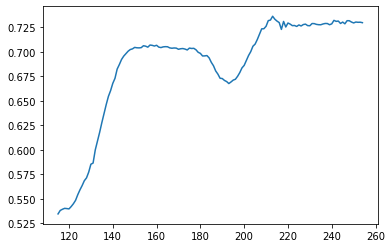

In [16]:
plt.plot(trial_list[1][2])  

### Somehow it detects jumping as well. perhaps these jump rears are made when animal rears then hits wall and then jumps up, or could make the detection more stringent 

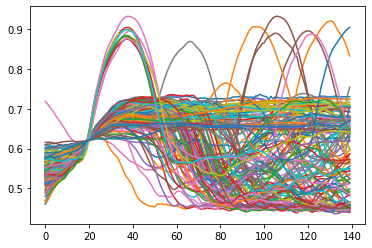

In [17]:
#print (len(trial_list[5]))
window= window_beg+window_end

#print(trial_list)
for trial in trial_list:
    #print (len(trial))
    if len(trial)==window:
        trial_len=range(window) 
        plt.plot(trial_len, trial[2],)

### Get only times when above.62 

### Create a histogram for each rear. - probably need to gen. an index where it ends and starts 

In [18]:
def Z_period_dynamics_beg_end(positions):
    """get every rear event in center of arena
    
    If animal gets above .62 detect it as one until below again
    
    PARAMS
    ------------
    positions : DataFrame 
    
    Returns
    ------------
    Data Frame with all rears position (begining of rear) and time. 

    """
    high =0 
    low = 0
    switch = 0 
    last = .60
    last2=.60
    high_points=[]
    high_points_end=[]
    z= positions[2]
    count = 0 
    for height in z: 
        if height >.62 and last<.62:
            high +=1  
            #if  (X_cut_min+cut)< positions[1][count]<(X_cut_max-cut) and (Y_cut_min+cut)< positions[3][count]<(Y_cut_max-cut):
            high_points.append((positions[0][count],positions[1][count],positions[3][count],positions[2][count]))
        last = height
        #print("beg" , last)
        if height <.62 and last2>.62:
            high +=1  
            #if  (X_cut_min+cut)< positions[1][count]<(X_cut_max-cut) and (Y_cut_min+cut)< positions[3][count]<(Y_cut_max-cut):
            high_points_end.append((positions[0][count],positions[1][count],positions[3][count],positions[2][count]))
        last2 = height
        count +=1
        #print("end", last)
    return pd.DataFrame(high_points), pd.DataFrame(high_points_end)
Z_points_beg,Z_points_end = Z_period_dynamics_beg_end(FS03_position)
Z_points_beg,Z_points_end

(                 0      1      2     3
 0   1615566506.380 -0.509  0.334 0.628
 1   1615566510.780 -0.441  0.248 0.625
 2   1615566529.700 -0.425  0.719 0.629
 3   1615566534.740 -0.568  1.607 0.622
 4   1615566538.190 -0.452 -0.021 0.621
 5   1615566539.090 -0.657  0.009 0.620
 6   1615566544.490  0.165  1.646 0.625
 7   1615566547.110 -0.583  1.587 0.622
 8   1615566551.770  0.095 -0.035 0.624
 9   1615566558.720 -0.621  1.285 0.627
 10  1615566562.340 -0.570  0.019 0.640
 11  1615566565.260 -0.509 -0.037 0.625
 12  1615566568.820  0.062  0.048 0.622
 13  1615566569.830  0.050 -0.048 0.620
 14  1615566572.920 -0.501  0.392 0.625
 15  1615566574.530 -0.487  0.271 0.622
 16  1615566575.840 -0.641  0.253 0.623
 17  1615566591.010 -0.488  0.341 0.620
 18  1615566592.450 -0.640  0.484 0.623
 19  1615566603.830 -0.561  0.296 0.628
 20  1615566607.220 -0.598  0.238 0.625
 21  1615566611.580  0.123  0.269 0.626
 22  1615566616.220 -0.502  1.679 0.623
 23  1615566621.220 -0.024 -0.018 0.621


### Plot Histogram of lenght of rears

1615568313.73 1615568315.05


(array([185.,  51.,  20.,   4.,   6.,   2.,   2.,   0.,   0.,   1.]),
 array([ 0.01999998,  1.09799998,  2.17599998,  3.25399997,  4.33199997,
         5.40999997,  6.48799996,  7.56599996,  8.64399996,  9.72199996,
        10.79999995]),
 <a list of 10 Patch objects>)

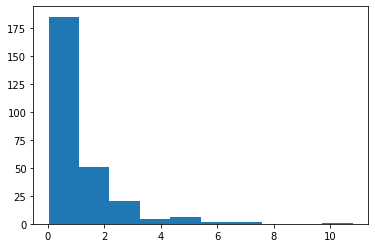

In [19]:
print (Z_points_beg.iloc[-1][0],Z_points_end.iloc[-1][0])
k=Z_points_end.iloc[:][0]-Z_points_beg[:][0]

plt.hist(k)

In [20]:
def make_rear_dyn_whole(position_data, rear_time_beg, rear_time_end ,metadata):
    """
    Generate trials where animal is above .62 "rearing"  
    
    PARAMS
    ------------
    positions : DataFrame 
    rear_time :data frame of timing of rears - beg and and end. 
    metadata : data frame of metadata to be used for invisible rears and attempts. 
    
    Returns
    ------------
    trial_list: list of numpy arrays position data [time, x, y, z] with windows defined in samples. 
    rear_time: list of rears detected
    trial_visible: list of booleans referring visibility of trial (True - visible, False- invisible
    before_beacon: list of positions before the first beacon appears
    """
    


    trial_list = []
    #print(beacon_data.iloc[:, -2:])
    trial_beacon = rear_time_end.iloc[:, -2:]
    
    sampling_rate = position_data.iloc[1, 0] - position_data.iloc[0, 0]
    rear_time_beg_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time_beg.iloc[:, 0]
    ]
    rear_time_end_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time_end.iloc[:, 0]
    ]

    trial_list.append(position_data[rear_time_beg_idx[0]:rear_time_end_idx[0]])
    for i in range(len(rear_time_end_idx)):
        if i != len(rear_time_end_idx) - 1:
            trial = position_data[
                rear_time_beg_idx[i]:rear_time_end_idx[i]]
        else:
            print('last rear')#trial = position_data[rear_time_beg_idx[i]:]
        trial_list.append(trial)
    #before_beacon = position_data[:rear_time_idx[0]]
    visible = []
    trial_visible = [True] * len(trial_list)
    invisible_time = eval(metadata['invisible_time'].item())
    invisible_index = eval(metadata['invisible_list'].item())

    for n, trial in enumerate(trial_list):
        trial_visible_ = np.ones_like(trial)
        if n in invisible_index:
            time_after = np.cumsum(trial.iloc[1:, 0] - trial.iloc[:-1, 0])
            if time_after.iloc[-1] > invisible_time:
                invisible_end = np.where(time_after >= invisible_time)[0][0]
                trial_visible_ = trial_visible_[:invisible_end]
            trial_visible[n] = False
        visible.append(trial_visible_)

    return trial_list, trial_beacon, visible, trial_visible

trial_list, trial_beacon, visible, trial_visible=make_rear_dyn_whole(position_data =FS03_position , 
                                                               rear_time_beg=Z_points_beg, rear_time_end=Z_points_end,
                                                                     metadata=FS03_metadata )


last rear


1.4199998378753662


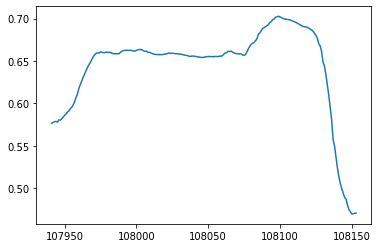

In [190]:
#print(trial_list[2][0][-1])

print (trial_list[2][0].loc[trial_list[2][0].index[-1]] -trial_list[2][0].loc[trial_list[2][0].index[0]] )
plt.plot(trial_list[-1][2]) 

In [191]:
200*250*150

7500000

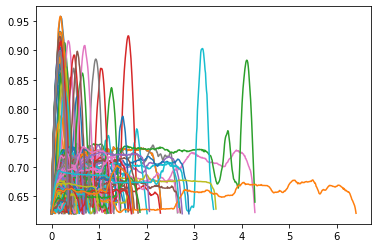

In [22]:
#print (len(trial_list[5]))



#print(trial_list)
for trial in trial_list: 
    #end= (trial[0].loc[trial[0].index[-1]] -trial[0].loc[trial[0].index[0]])
    #beg = 0
    trial_time=range(len(trial[0]))  # runnign into division of small numbers unfortunately to be able to correct the timing 
    time = [i/100 for i in trial_time] 
    plt.plot(time, trial[2],)

### TODO: 
    Make all into a function which takes in position and generates only rearign trajectories 

In [185]:
def Rearing_traj (position_data,metadata,buffer=10):
    """
    Generate trials +- buffer aorund where animal is above .62 "rearing" 
  
    PARAMS
    ------------
    positions : DataFrame 
    metadata : data frame of metadata to be used for invisible rears and attempts. 
    buffer : how many sampled before and after to see - could run into errors here!!
    
    Returns
    ------------
    trial_list: list of numpy arrays position data [time, x, y, z] . 
    rear_time: list of rears detected
    trial_visible: list of booleans referring visibility of trial (True - visible, False- invisible)
    """

    
    rear_time_beg,rear_time_end = Z_period_dynamics_beg_end(position_data)
    
    
    trial_list = []
    #print(beacon_data.iloc[:, -2:])
    trial_beacon = rear_time_end.iloc[:, -2:]
    
    sampling_rate = position_data.iloc[1, 0] - position_data.iloc[0, 0]
    rear_time_beg_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time_beg.iloc[:, 0]
    ]
    rear_time_end_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time_end.iloc[:, 0]
    ]

    trial_list.append(position_data[rear_time_beg_idx[0]-buffer:rear_time_end_idx[0]+buffer])
    for i in range(len(rear_time_end_idx)):
        if i != len(rear_time_end_idx) - 1:
            trial = position_data[rear_time_beg_idx[i]-buffer:rear_time_end_idx[i]+buffer]
        else:
            print('last rear')#trial = position_data[rear_time_beg_idx[i]:]
        trial_list.append(trial)
    visible = []
    trial_visible = [True] * len(trial_list)
    invisible_time = eval(metadata['invisible_time'].item())
    invisible_index = eval(metadata['invisible_list'].item())

    ### Had to uncoment this for now due to some rears ending past the recordign lenght. 
    
#     for n, trial in enumerate(trial_list):
#         trial_visible_ = np.ones_like(trial)
#         if n in invisible_index:
#             time_after = np.cumsum(trial.iloc[1:, 0] - trial.iloc[:-1, 0])
#             if time_after.iloc[-1] > invisible_time:
#                 invisible_end = np.where(time_after >= invisible_time)[0][0]
#                 trial_visible_ = trial_visible_[:invisible_end]
#             trial_visible[n] = False
#         visible.append(trial_visible_)

    return trial_list, trial_beacon, #visible, trial_visible

trial_list, trial_beacon, =Rearing_traj(position_data =FS03_position ,metadata=FS03_metadata, buffer =20 )

last rear


In [187]:
trial_list[3].type

AttributeError: 'DataFrame' object has no attribute 'type'

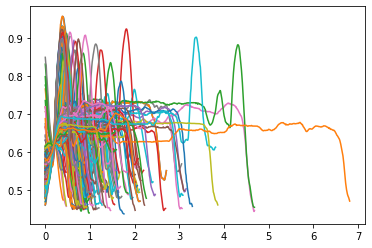

In [162]:
for trial in trial_list: 
    trial_time=range(len(trial[0]))  # runnign into division of small numbers unfortunately to be able to correct the timing 
    time = [i/100 for i in trial_time] 
    plt.plot(time, trial[2],)

### Plot only visibel or invisible rears seperate 

In [149]:
print(trial_visible[0])

True


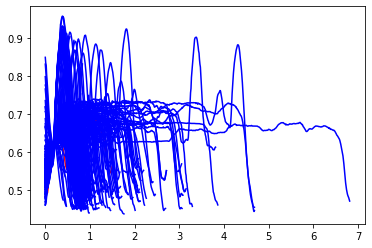

In [150]:
for i in range(len(trial_list[0])): 
    trial_time=range(len(trial_list[i]))
    time = [i/100 for i in trial_time] 
    if trial_visible[i]:
        plt.plot(time,trial_list[i][2],c='blue')
    else:
        plt.plot(time,trial_list[i][2],c='red')

### TODO: 
    Combine rearign hist with the ending of the rears and generate the trajectories in between and save them also. 

#### 1. Import loader function from rearign hist. 
2. Generate hist for the begginging. 
3. generate endings for the give trials 
4. create trajectorie. 
5 use initial rearing fce to update if visibel or not and hwo far away from beacon the intial moment is. 
666666. Plottign notebook 

In [30]:
import rear_analysis

20211006-141250
Match found making rearing file


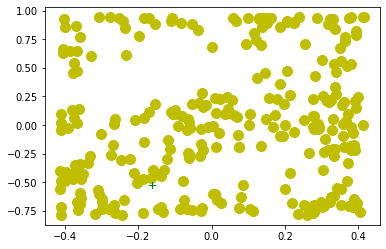

20211007-162516
Match found making rearing file


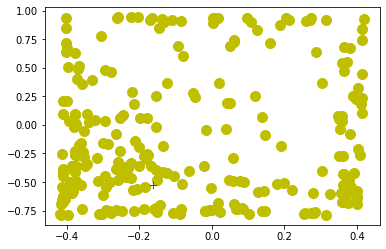

20211011-083149
Match found making rearing file


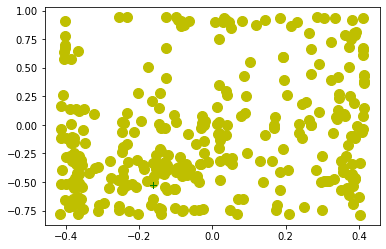

20211014-143948
Match found making rearing file


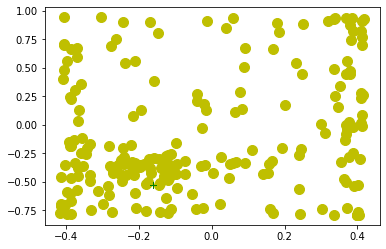

20211015-172253
Match found making rearing file


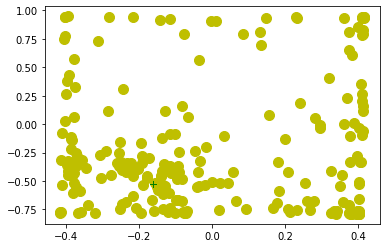

20211019-154901
Match found making rearing file


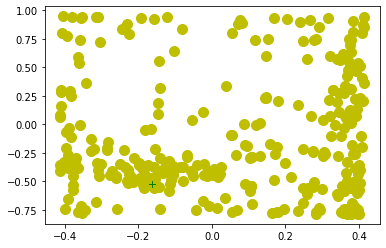

20211022-150313
Match found making rearing file


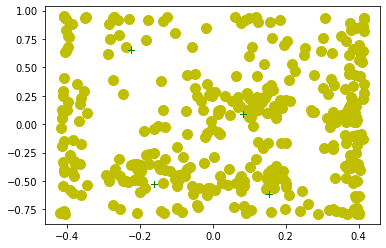

20211023-175530
Match found making rearing file


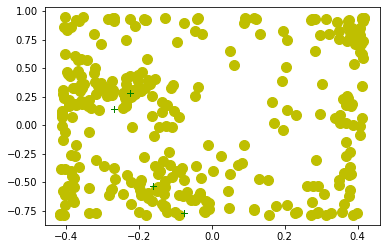

20211025-123138
Match found making rearing file


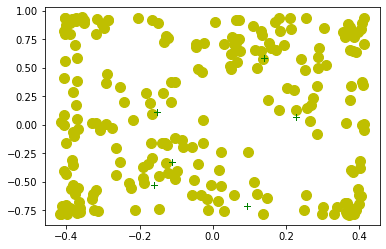

20211026-160814
Match found making rearing file


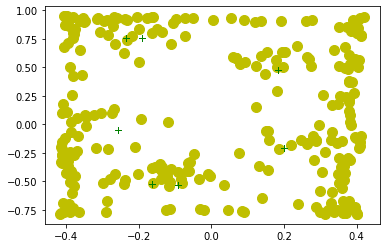

20211027-204349
Match found making rearing file


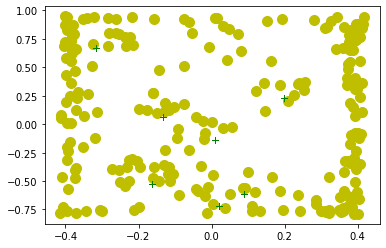

20211029-165158
Match found making rearing file


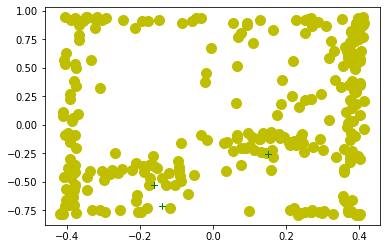

20211101-195542
Match found making rearing file


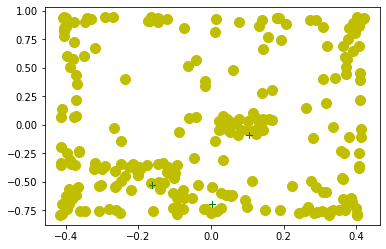

20211102-154758
Match found making rearing file


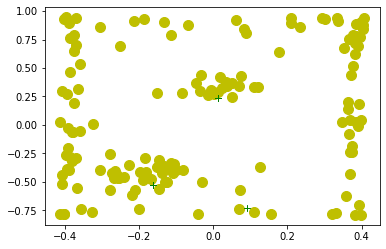

20211103-152808
Match found making rearing file


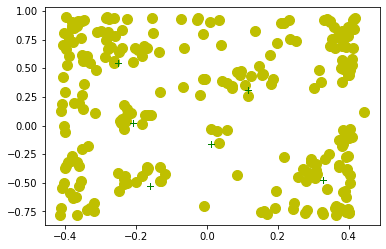

20211104-155523
Match found making rearing file


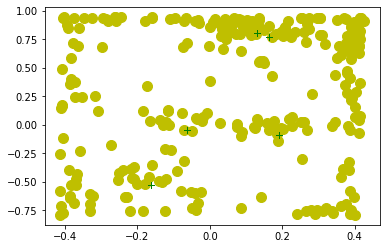

20211108-162543
Match found making rearing file


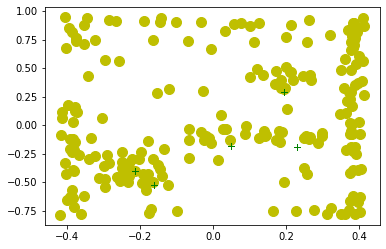

20211109-142223
Match found making rearing file


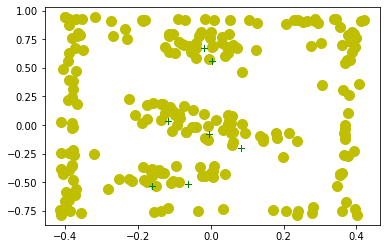

20211110-133521
Match found making rearing file


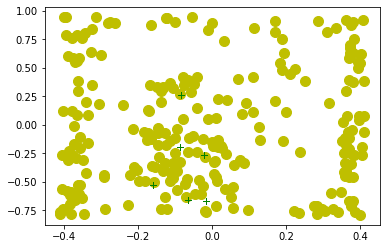

20211111-161219
Match found making rearing file


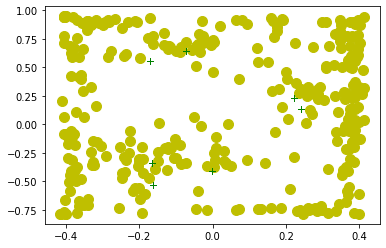

20211114-174950
Match found making rearing file


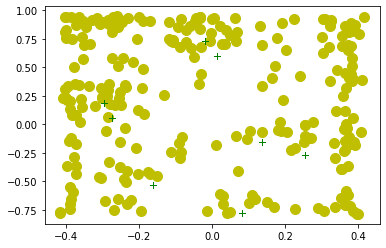

20211115-171708
Match found making rearing file


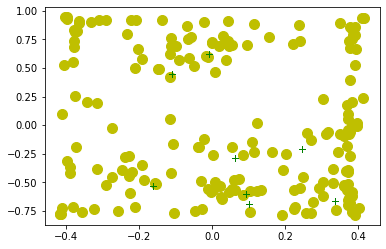

20211116-163603
Match found making rearing file


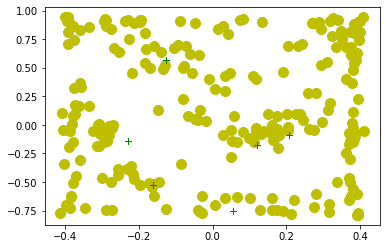

20211117-210800
Match found making rearing file


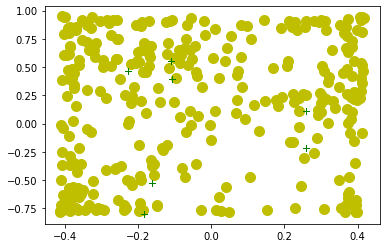

20211118-161542
Match found making rearing file


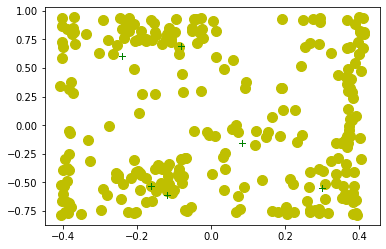

20211120-180648
Match found making rearing file


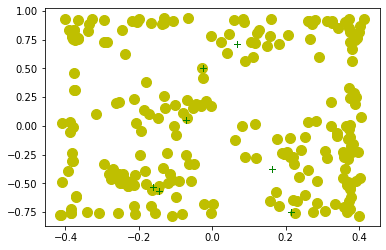

20211123-181538
Match found making rearing file


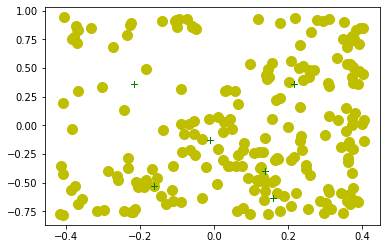

20211124-210735
Match found making rearing file


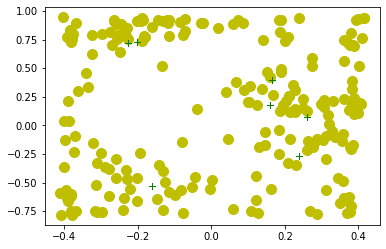

20211126-100947
Match found making rearing file


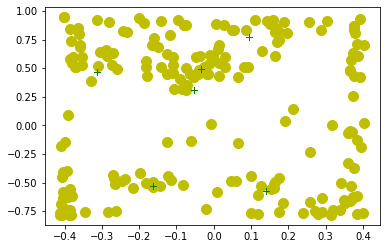

20211129-123436
Match found making rearing file


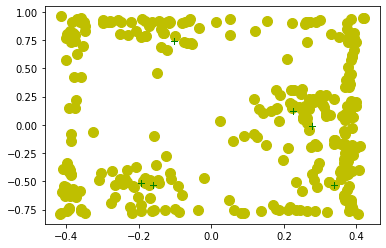

20211006-154014
Match found making rearing file


C:\Users\Fabian\Desktop\Analysis\Round3_FS03_FS06\Code\rear_analysis.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  beacon[6][ind] = 2
C:\Users\Fabian\Desktop\Analysis\Round3_FS03_FS06\Code\rear_analysis.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  beacon[7][ind] = beacon[0][ind]
C:\Users\Fabian\Desktop\Analysis\Round3_FS03_FS06\Code\rear_analysis.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  beacon[7][ind] = beacon[0][ind]
C:\Users\Fabian\Desktop\Analysis\Round

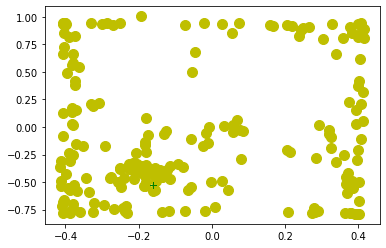

20211007-150456
Match found making rearing file


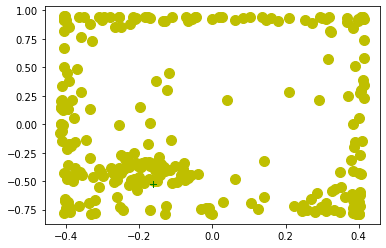

20211011-094820
Match found making rearing file


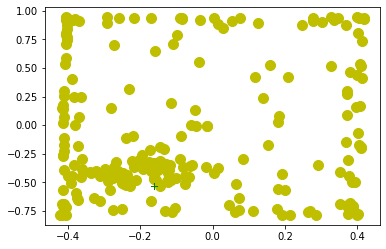

20211014-160224
Match found making rearing file


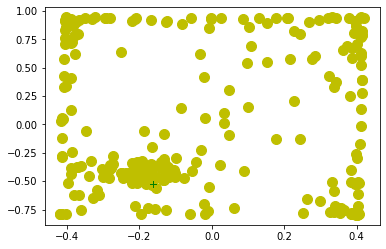

20211015-161036
Match found making rearing file


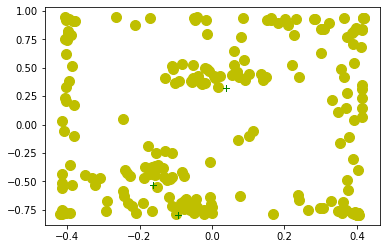

20211019-170531
Match found making rearing file


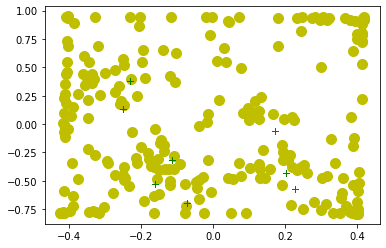

20211022-142453
Match found making rearing file


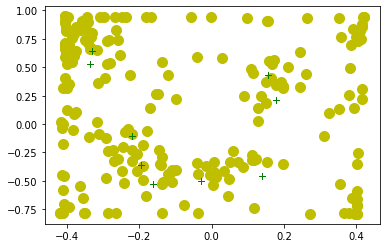

20211023-191308
Match found making rearing file


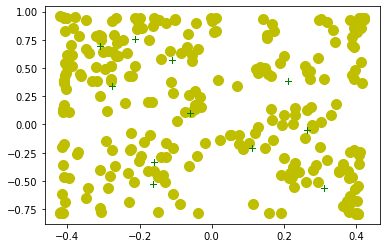

20211025-143051
Match found making rearing file


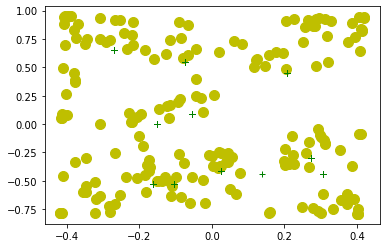

20211026-152717
Match found making rearing file


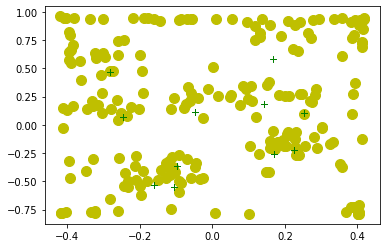

20211027-184908
Match found making rearing file


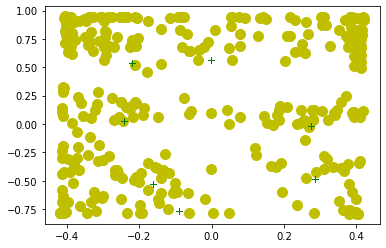

20211029-155803
Match found making rearing file


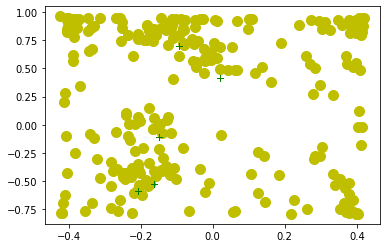

20211101-184002
Match found making rearing file


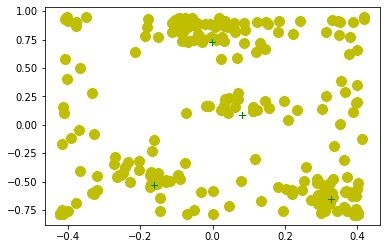

20211102-210824
Match found making rearing file


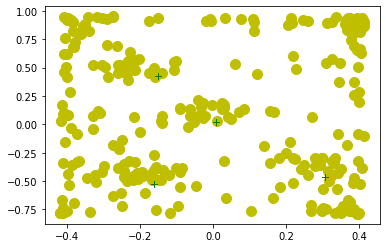

20211103-135341
Match found making rearing file


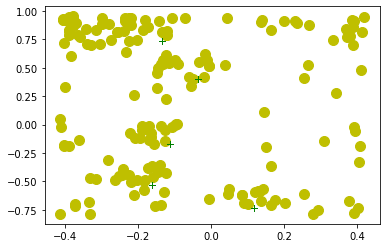

20211104-135728
Match found making rearing file


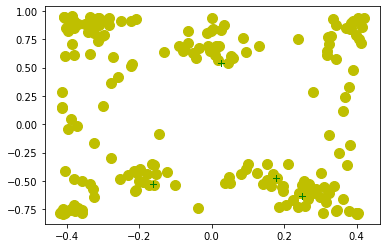

20211108-150654
Match found making rearing file


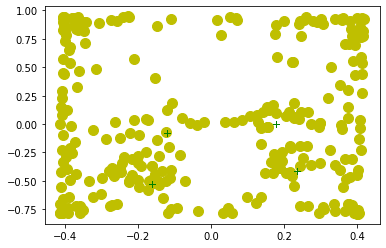

20211109-153259
Match found making rearing file


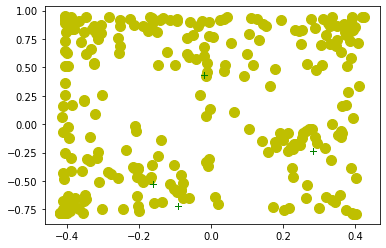

20211110-152334
Match found making rearing file


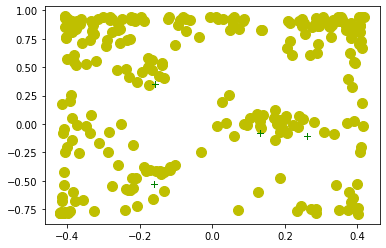

20211111-133124
Match found making rearing file


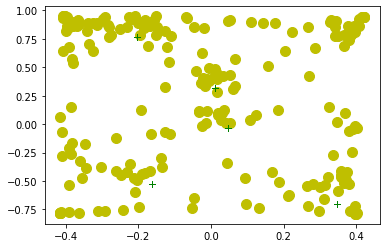

20211114-170917
Match found making rearing file


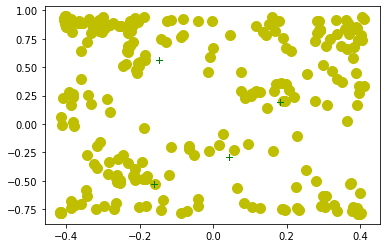

20211115-152956
Match found making rearing file


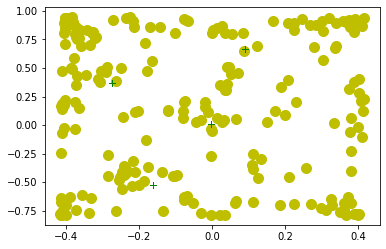

20211116-144028
Match found making rearing file


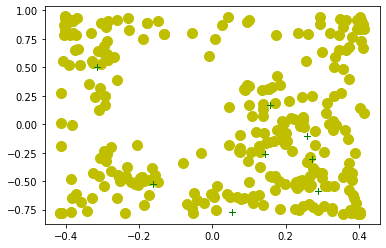

20211117-141817
Match found making rearing file


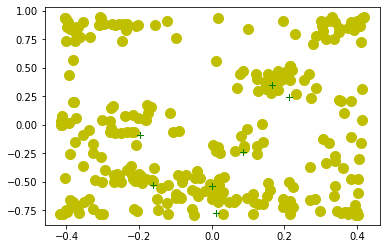

20211118-195217
Match found making rearing file


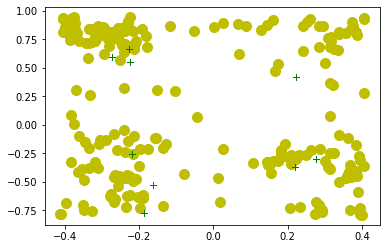

20211120-165441
Match found making rearing file


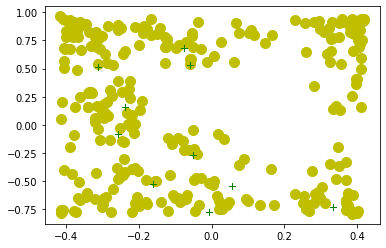

20211123-193246
Match found making rearing file


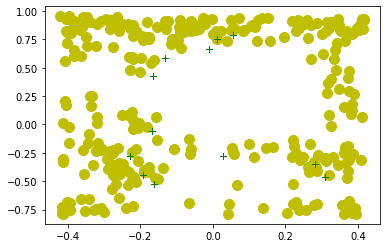

20211124-223122
Match found making rearing file


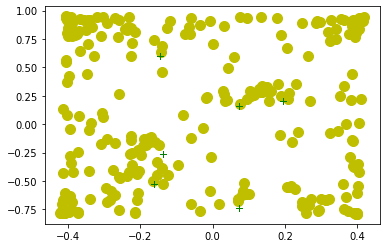

20211126-112402
Match found making rearing file


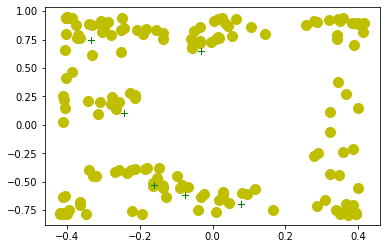

20211129-110431
Match found making rearing file


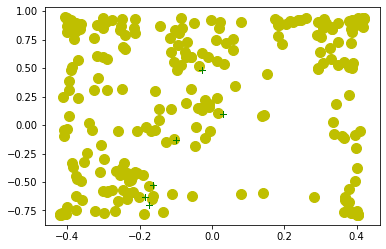

20211006-145401
Match found making rearing file


C:\Users\Fabian\Desktop\Analysis\Round3_FS03_FS06\Code\rear_analysis.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  beacon[6][ind] = 2
C:\Users\Fabian\Desktop\Analysis\Round3_FS03_FS06\Code\rear_analysis.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  beacon[7][ind] = beacon[0][ind]
C:\Users\Fabian\Desktop\Analysis\Round3_FS03_FS06\Code\rear_analysis.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  beacon[7][ind] = beacon[0][ind - 1] + invisible_time
C:\Users\Fabian\D

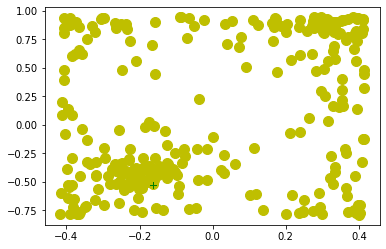

20211007-155054
Match found making rearing file


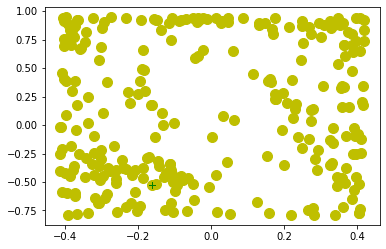

20211011-090846
Match found making rearing file


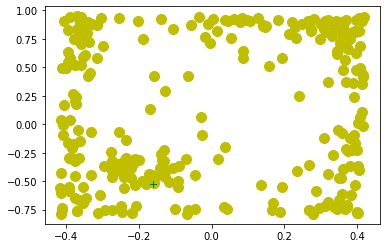

20211014-152539
Match found making rearing file


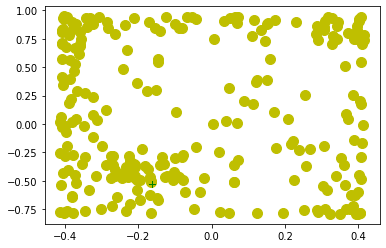

20211015-164632
Match found making rearing file


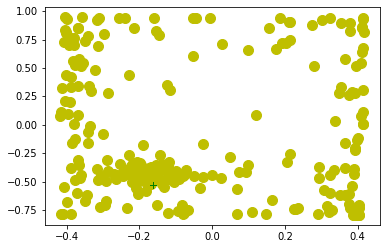

20211019-162543
Match found making rearing file


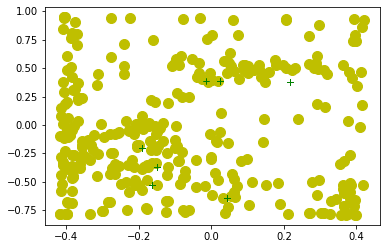

20211022-131040
Match found making rearing file


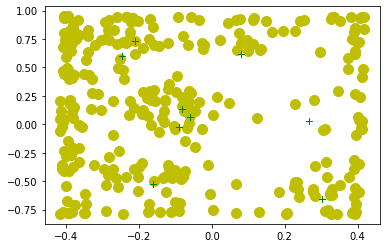

20211023-183301
Match found making rearing file


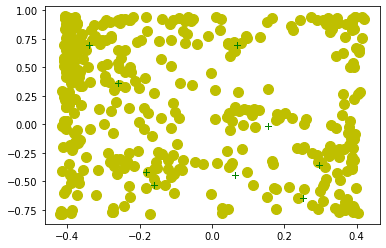

20211025-135419
Match found making rearing file


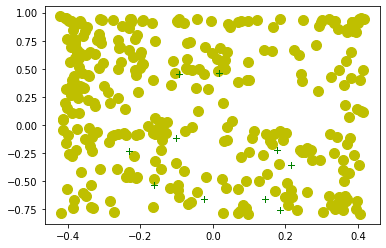

20211026-164331
Match found making rearing file


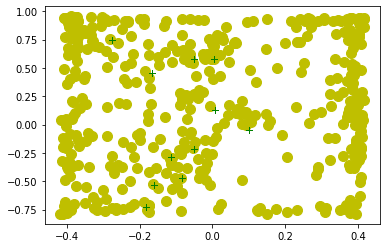

20211027-200900
Match found making rearing file


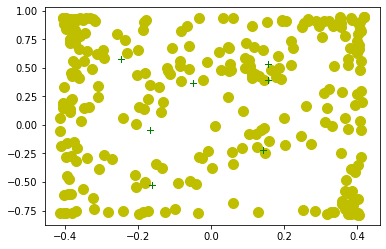

20211029-172916
Match found making rearing file


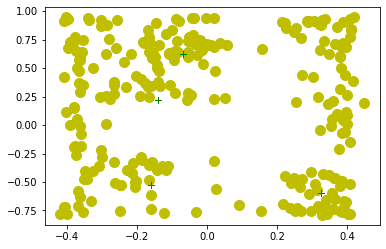

20211101-191934
Match found making rearing file


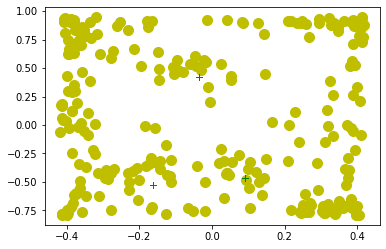

20211102-151034
Match found making rearing file


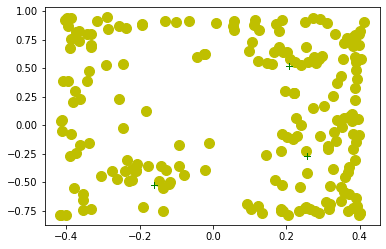

20211103-144559
Match found making rearing file


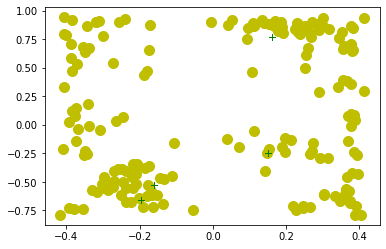

20211104-151720
Match found making rearing file


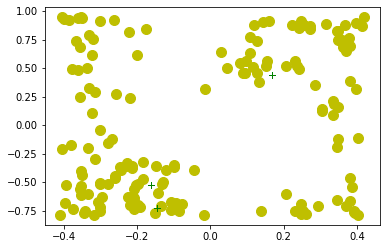

20211108-154456
Match found making rearing file


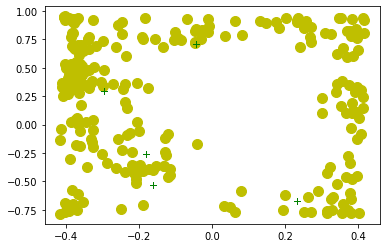

20211109-134609
Match found making rearing file


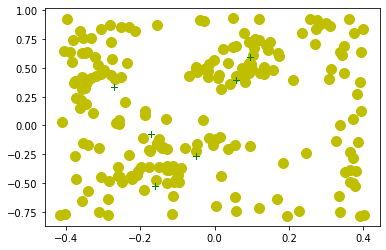

20211110-144941
Match found making rearing file


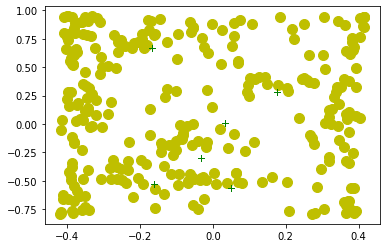

20211111-164730
Match found making rearing file


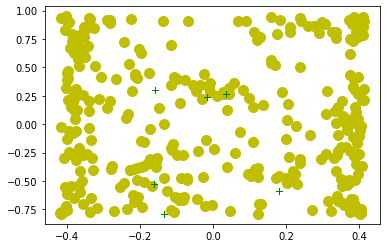

20211114-182416
Match found making rearing file


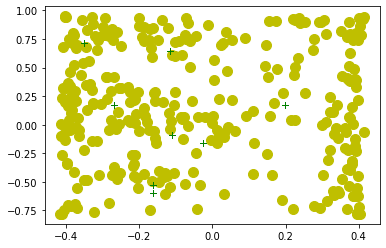

20211115-164349
Match found making rearing file


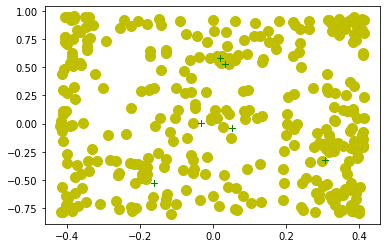

20211116-160113
Match found making rearing file


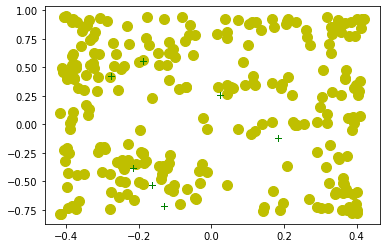

20211117-203000
Match found making rearing file


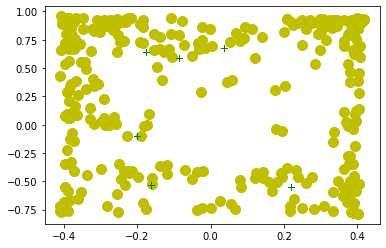

20211118-182248
Match found making rearing file


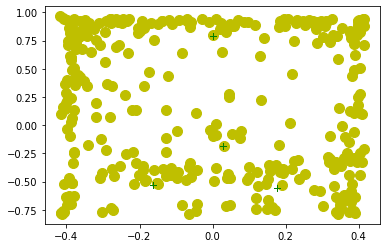

20211120-183947
Match found making rearing file


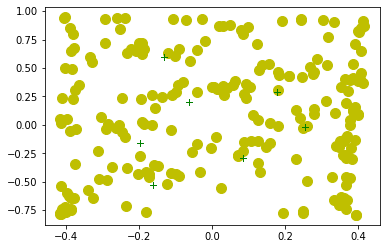

20211123-185323
Match found making rearing file


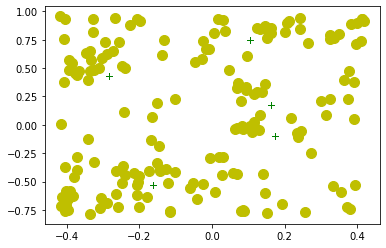

20211124-215755
Match found making rearing file


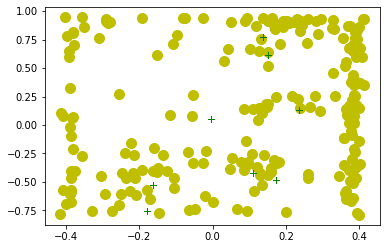

20211126-104417
Match found making rearing file


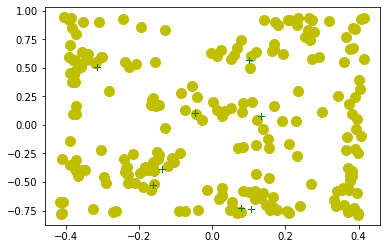

20211129-131454
Match found making rearing file


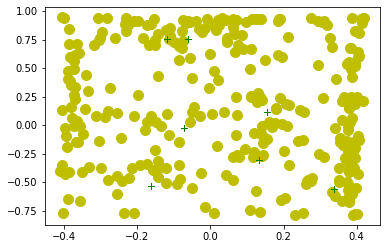

20211006-161633
Match found making rearing file


C:\Users\Fabian\Desktop\Analysis\Round3_FS03_FS06\Code\rear_analysis.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  beacon[6][ind] = 2
C:\Users\Fabian\Desktop\Analysis\Round3_FS03_FS06\Code\rear_analysis.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  beacon[7][ind] = beacon[0][ind]
C:\Users\Fabian\Desktop\Analysis\Round3_FS03_FS06\Code\rear_analysis.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  beacon[7][ind] = beacon[0][ind - 1] + invisible_time
C:\Users\Fabian\D

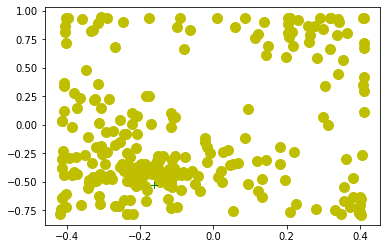

20211007-142813
Match found making rearing file


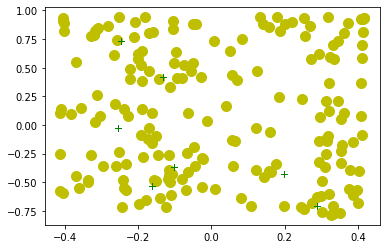

20211011-102330
Match found making rearing file


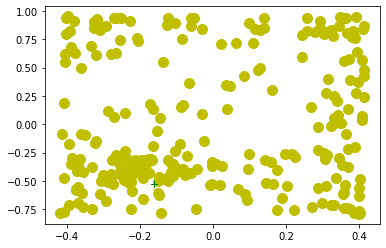

20211014-163731
Match found making rearing file


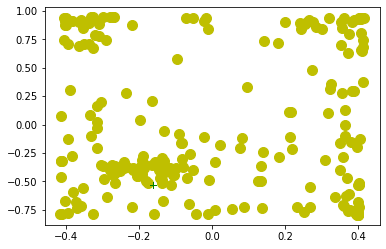

20211015-175713
Match found making rearing file


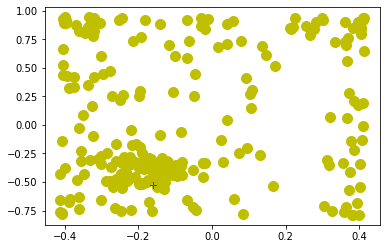

20211019-174041
Match found making rearing file


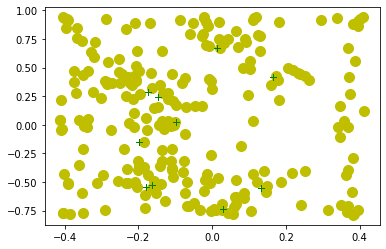

20211022-134933
Match found making rearing file


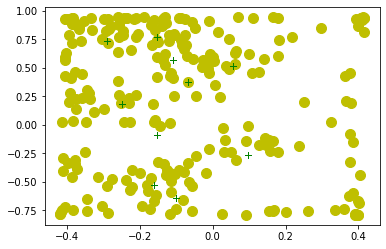

20211023-194927
Match found making rearing file


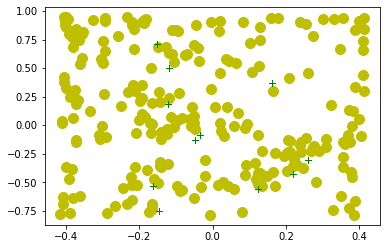

20211025-131004
Match found making rearing file


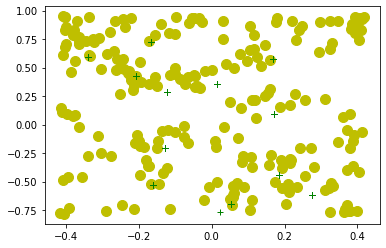

20211026-144902
Match found making rearing file


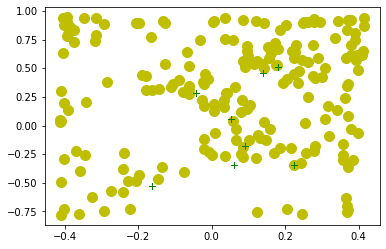

20211027-192913
Match found making rearing file


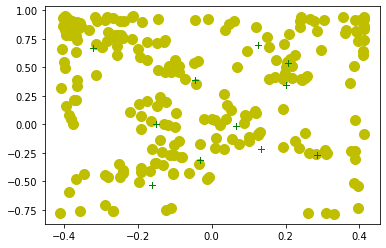

20211029-152124
Match found making rearing file


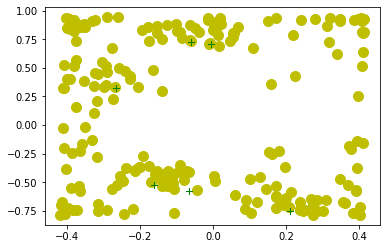

20211101-180402
Match found making rearing file


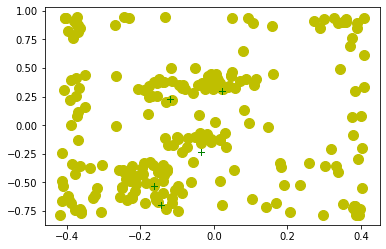

20211102-214422
Match found making rearing file


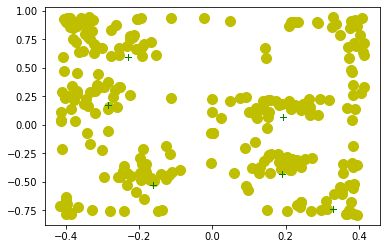

20211103-131846
Match found making rearing file


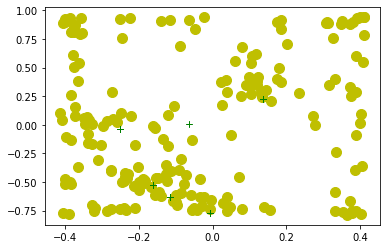

20211104-143545
Match found making rearing file


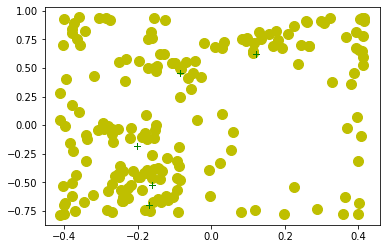

20211108-141817
Match found making rearing file


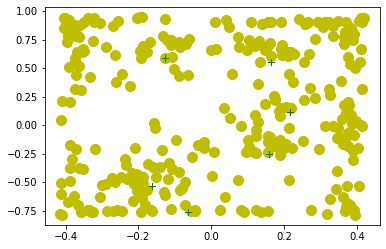

20211109-145946
Match found making rearing file


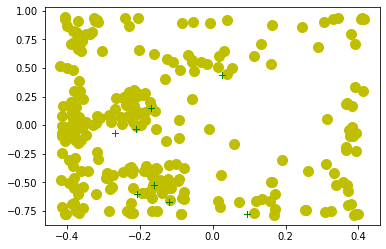

20211110-140949
Match found making rearing file


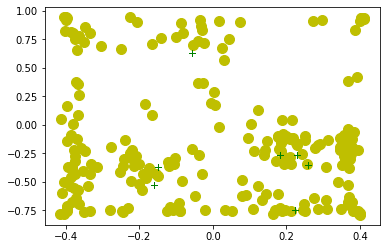

20211111-152325
Match found making rearing file


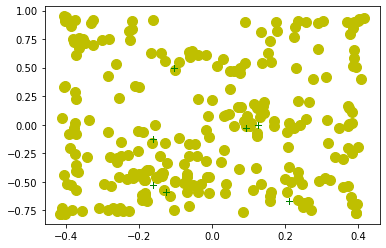

20211114-163407
Match found making rearing file


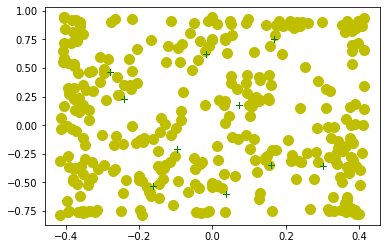

20211115-160408
Match found making rearing file


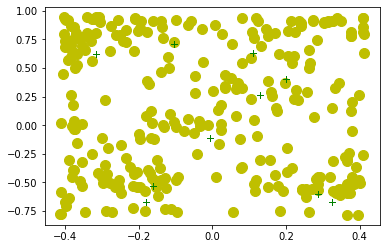

20211116-151859
Match found making rearing file


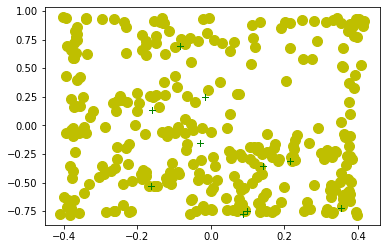

20211117-145403
Match found making rearing file


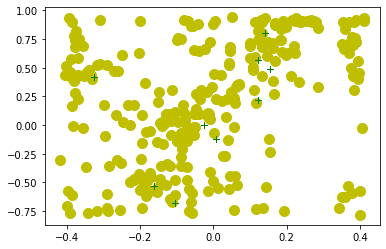

20211118-191622
Match found making rearing file


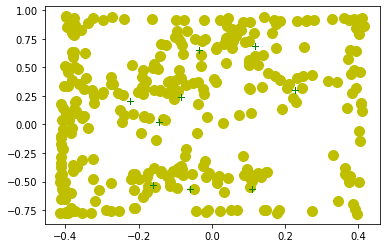

20211120-172908
Match found making rearing file


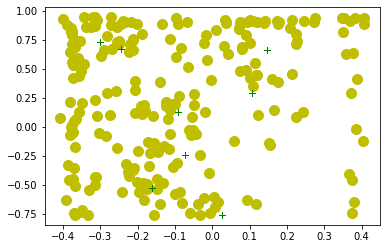

20211123-200731
Match found making rearing file


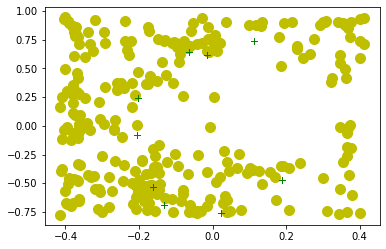

20211124-231043
Match found making rearing file


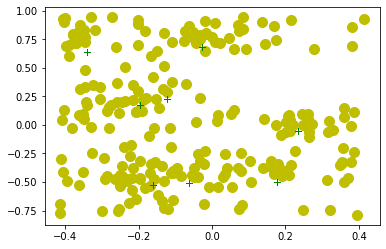

20211126-115910
Match found making rearing file


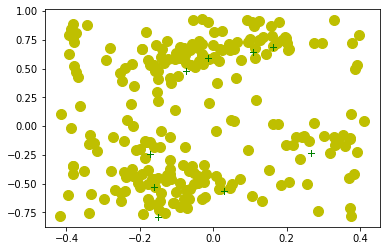

20211129-114115
Match found making rearing file


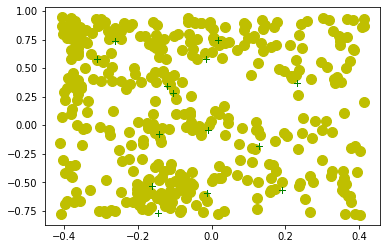

In [32]:
rear_analysis.crawl_make_and_safe('FS08',In_arena = False,Save_plots=False)
rear_analysis.crawl_make_and_safe('FS10',In_arena = False,Save_plots=False)
rear_analysis.crawl_make_and_safe('FS09',In_arena = False,Save_plots=False)
rear_analysis.crawl_make_and_safe('FS11',In_arena = False,Save_plots=False)

In [83]:
FS11=pd.read_excel(processed +'FS11_rears_all.xlsx', index_col=0)

In [89]:
FS11_one_day= rear_analysis.day_cutter('FS11',In_arena=True, days=(20,21))

###  PROBLEM   Currently the approach was to generate the rearinf trajectories for each session, ran into a problem of how to add lists of dataframes together.Maybe an easier approach is to make a single session function where I use the Tag date and then genrate it for a given sessio and then use the beacon_rears_all to find how far from beacon etc.- Perhaps I woudl still run into the same problem of concatanatign lists of dataframes.  

In [243]:

def Make_rear_dyn (rat_ID) :
    """
    Should crawl through, check for time and data and generate rear ends and begs for a given time 
    then make all trajectoriess into Data frame??
    """          
    how_many = 0
    substring = "BPositions_"
    position = "position_2"
    beacon = 'beacons'
    metadata = 'metadata'
    animal = '//10.153.170.3/storage2/fabian/data/project/' + rat_ID
    average_rears = []
    animal_dir = os.path.join(figures + rat_ID)
    if not os.path.isdir(animal_dir):
        os.makedirs(animal_dir)
    animal_process = os.path.join(processed + rat_ID)
    if not os.path.isdir(animal_process):
        os.makedirs(animal_process)
    #rearing = pd.DataFrame()
    
        
    for dirpath, dirnames, files in os.walk(animal, topdown=True):
        fullstring = dirpath
        #if how_many<3:
        for file_name in files:
            #print(file_name)
            fullstring = dirpath
            if beacon in file_name:
                beacons = pd.read_csv(dirpath + '/' + file_name, sep=" ", header=None, engine='python')
                beacon_date = list(file_name)
            if metadata in file_name:
                metadatas = pd.read_csv(dirpath + '/' + file_name, sep=" : ", header=None, engine='python')
                df = metadatas.T
                df = df.rename(columns=df.iloc[0])
                df = df.drop(df.index[0])
                if int(df['Pellets'].values[0]) > 1:

                    invisible_time = int(df['invisible_time'].values[0])
                    light_off = int(df['light_off'].values[0])
                    location_change = (df['position_change'].values[0])
                    Computer_time_was = (df['Computer time was'].values[0])
                    # print(int(Computer_time_was))
                    time_stamp = datetime.fromtimestamp(int(float(Computer_time_was))).strftime('%Y%m%d-%H%M%S')
                    print(time_stamp)
            if position in file_name:
                positions = pd.read_csv(dirpath + '/' + file_name, sep=" ", header=None, engine='python')
                positions_date = list(file_name)
                if beacon_date[-9:] == positions_date[-9:]:
                    print("Match found making rearing file")
                    how_many += 1

                    rearing_df, trial_beacon = Rearing_traj (positions,df,buffer=0)
                    #rearing_df = pd.DataFrame.from_records(rearing_df)
                    #print (rearing_df)
                    ## save in HDF5

                    if not os.path.exists(processed+'/'+ rat_ID):
                        os.makedirs(processed+'/'+ rat_ID) 
                    with h5py.File(processed+'/'+ rat_ID +'/' +rat_ID +'.h5' ,mode='a') as f:
                        grp = f.create_group(time_stamp)
                        for i in range(len(rearing_df)):
                            name = str(i)
                            grp.create_dataset(name,data = rearing_df[i])

                else:
                    print('bad match')

    return  
rearing_dyn = Make_rear_dyn ("FS08")
rearing_dyn = Make_rear_dyn ("FS10")


20211006-141250
Match found making rearing file
last rear
20211007-162516
Match found making rearing file
last rear
20211011-083149
Match found making rearing file
last rear
20211014-143948
Match found making rearing file
last rear
20211015-172253
Match found making rearing file
last rear
20211019-154901
Match found making rearing file
last rear
20211022-150313
Match found making rearing file
last rear
20211023-175530
Match found making rearing file
last rear
20211025-123138
Match found making rearing file
last rear
20211026-160814
Match found making rearing file
last rear
20211027-204349
Match found making rearing file
last rear
20211029-165158
Match found making rearing file
last rear
20211101-195542
Match found making rearing file
last rear
20211102-154758
Match found making rearing file
last rear
20211103-152808
Match found making rearing file
last rear
20211104-155523
Match found making rearing file
last rear
20211108-162543
Match found making rearing file
last rear
20211109-14222

# GRAVEYARD

### Calculate how much time per rear period just from the position data

In [146]:
def average_Z_time_period(session_list):
    total = []
    for session in session_list: 
        total.append(Z_periods(session))
    print (total)
    average = statistics.median(total)
    #plt.bar(range(len(total)),total)
    return total

def Z_periods(positions): 
    high =0 
    low = 0
    switch = 0 
    last = .60
    z= positions[2]
    for height in z: 
        if height >.62 and last<.62:
            high +=1  
        last = height
    return high

def Z_time(positions): 
    high =0 
    low=0 
    z= positions[2]
    for height in z: 
        if height >.62:
            high +=1       
    percent =  high/ z.size*100
    return percent




Animals=['//10.153.170.3/storage2/fabian/data/raw/FS03/Event_files_FS03/','//10.153.170.3/storage2/fabian/data/raw/FS04/Event_files_FS04/']
Names = ['FS03','FS04']

def All_new_animals(Animal_names):
    
    
    fig, ax = plt.subplots(dpi= 100)
    
    
    n=2
    for animal_ID in Animal_names:
        n+=1
        height_periods = []
        result=pd.DataFrame()
        for dirpath, dirnames, files in os.walk(animal_ID, topdown=True):
            for metadata in files:
                if fnmatch.fnmatch(metadata, 'position_*'):
                    k=(animal_ID+'/'+metadata)
                    day = pd.read_csv(k,sep=" ", header=None,engine='python')
                    height_periods.append(Z_periods(day))

        X_markers = range(len(height_periods))
        if n==3: 
            ax.bar(X_markers,height_periods, label= '%s' %Names[0],alpha=.5)  
        else:
            ax.bar(X_markers,height_periods, label= '%s' %Names[1],alpha=.5)  
        
    #ax.bar(range(len(list_of_days)),average_Z_time_period(list_of_days),label= 'old FS1',alpha=.2)
    #ax.bar(range(len(list_of_days2)),average_Z_time_period(list_of_days2),label= 'old FS2',alpha=.2)
    ax.set_ylabel('Rears')
    ax.set_xlabel('Session')
    ax.set_title('Rear periods during electrophysiology only')
    
    ax.legend()  
    #ax.set_xticklabels(X_markers)
    plt.savefig(figures+'Number_of_rears_in_highzone_ephys_only.png', dpi = 300)
All_new_animals(Animals) 

Animals=['//10.153.170.3/storage2/fabian/data/raw/FS03/Event_files_FS03/','//10.153.170.3/storage2/fabian/data/raw/FS04/Event_files_FS04/']

Names = ['FS03','FS04']

def All_new_animals_height(Animal_names):   
    
    plt.figure(figsize=(20,20))
    plt.ylim(.4, .8)
    plt.title('Distribution of Heights per sessions - electrophysiology FS03 and FS04')
    plt.ylabel("Animal height")
    
    n=2
    for animal_ID in Animal_names:
        n+=1
        height_time = []
        result=pd.DataFrame()
        for dirpath, dirnames, files in os.walk(animal_ID, topdown=True):
            for metadata in files:
                if fnmatch.fnmatch(metadata, 'position_*'):
                    k=(animal_ID+'/'+metadata)
                    day = pd.read_csv(k,sep=" ", header=None,engine='python')
                    height_time.append(Z_periods(day))
                    sns.distplot(day[2],vertical=True)
                        

    plt.savefig(figures+'FS3_6_Distribution of Heights per sessions_.png', dpi = 200)

All_new_animals_height(Animals) 


 
Animals=['//10.153.170.3/storage2/fabian/data/raw/FS03/Event_files_FS03/','//10.153.170.3/storage2/fabian/data/raw/FS04/Event_files_FS04/']

Names = ['FS03','FS04']

def All_new_animals_height_percent(Animal_names):
    
    fig, ax = plt.subplots(dpi= 300)
    ax.set_ylabel('percent of time in session rearing - electophysiology only')
    ax.set_xlabel('Session')
    ax.set_title('Percent time above .62m')
    
    n=2
    for animal_ID in Animal_names:
        n+=1
        height_time = []
        result=pd.DataFrame()
        for dirpath, dirnames, files in os.walk(animal_ID, topdown=True):
            for metadata in files:
                if fnmatch.fnmatch(metadata, 'position_*'):
                    k=(animal_ID+'/'+metadata)
                    day = pd.read_csv(k,sep=" ", header=None,engine='python')
                    height_time.append(Z_time(day))
        if n==3: 
            ax.plot(height_time, label= '%s' %Names[0]) 
        else:
            ax.plot(height_time, label= '%s' %Names[1]) 
         
    ax.legend() 
    #ax.set_xticklabels(range(len(height_time)))
    plt.savefig(figures+'Percent_time_in_highzone - electophysiology only.png', dpi = 200)
All_new_animals_height_percent(Animals) 
   

In [ ]:
position_data =FS03_position

In [41]:
def get_rear_distance_from_beacon(df_rears_corrected):
    dist=[]
    for row in df_rears_corrected.iterrows():
        #print(row[1][1])
        #print(row[1][4])
        #print(row[1][2])
        #print(row[1][5])
        dist.append(math.sqrt((row[1][1] - row[1][4])**2 + (row[1][2] - row[1][5])**2))

    return dist 
plt.hist(get_rear_distance_from_beacon(rearing))

NameError: name 'rearing' is not defined

In [42]:
def make_rear_dyn(position_data, rear_time ,metadata, window_beg=window_beg,window_end=window_end,in_arena=True):
    '''
    Return
    trial_list: list of numpy arrays position data [time, x, y, z] 
    rear_time: list of rears detected
    trial_visible: list of booleans referring visibility of trial (True - visible, False- invisible
    before_beacon: list of positions before the first beacon appears
    '''

    trial_list = []
    #print(beacon_data.iloc[:, -2:])
    trial_beacon = rear_time.iloc[:, -2:]
    sampling_rate = position_data.iloc[1, 0] - position_data.iloc[0, 0]
    rear_time_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time.iloc[:, 0]
    ]

    trial_list.append(position_data[:rear_time_idx[0]])
    for i in range(len(rear_time_idx)):
        if i != len(rear_time_idx) - 1:
            trial = position_data[
                rear_time_idx[i]-window_beg:rear_time_idx[i]+window_end]
        else:
            trial = position_data[rear_time_idx[i]:]
        trial_list.append(trial)
    before_beacon = position_data[:rear_time_idx[0]]
    visible = []
    trial_visible = [True] * len(trial_list)
    invisible_time = eval(metadata['invisible_time'].item())
    invisible_index = eval(metadata['invisible_list'].item())

    for n, trial in enumerate(trial_list):
        trial_visible_ = np.ones_like(trial)
        if n in invisible_index:
            time_after = np.cumsum(trial.iloc[1:, 0] - trial.iloc[:-1, 0])
            if time_after.iloc[-1] > invisible_time:
                invisible_end = np.where(time_after >= invisible_time)[0][0]
                trial_visible_ = trial_visible_[:invisible_end]
            trial_visible[n] = False
        visible.append(trial_visible_)

    return trial_list, trial_beacon, visible, trial_visible

trial_list, trial_beacon, visible, trial_visible=make_rear_dyn(position_data =FS03_position , 
                                                               rear_time= Z_points, metadata=FS03_metadata,window_beg=window_beg,window_end=window_end )